<a href="https://colab.research.google.com/github/RPeleja/WorkML/blob/main/ProjetoML_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import seaborn as sb
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve

In [64]:
from google.colab import drive

# it will ask for your google drive credentiaals
drive.mount('/content/drive/', force_remount=True)

#global path variable
path="/content/drive/MyDrive/Colab Notebooks/ML/ProjetoML_WINE/"

Mounted at /content/drive/


In [65]:
# Dataset File Path
filePath_red = path + "winequality-red.csv"
filePath_white = path + "winequality-white.csv"
filePath_weather = path + "weather-porto-2024.csv"

df1 = pd.read_csv(filePath_red)
df1['type'] = '0'
df2 = pd.read_csv(filePath_white)
df2['type'] = '1'

weather_df = pd.read_csv(filePath_weather, delimiter=';')

wine_df = pd.concat([df1, df2], ignore_index=True)

print("Nr. rows - wines: ", len(wine_df))

Nr. rows - wines:  6497


In [66]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [67]:
# Filter for September and October - wine wascollected between September and October
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format='%d/%m/%Y %H:%M')
weather_filtered = weather_df[(weather_df['timestamp'].dt.month >= 9) & (weather_df['timestamp'].dt.month <= 10)]

# Generate random dates within the weather data range for the wine dataset
min_date = weather_filtered['timestamp'].min()
max_date = weather_filtered['timestamp'].max()
wine_df['timestamp'] = np.random.choice(pd.date_range(min_date, max_date), size=len(wine_df))

# Merge datasets on timestamp
df = pd.merge_asof(wine_df.sort_values('timestamp'),
                             weather_df.sort_values('timestamp'),
                             on='timestamp',
                             direction='nearest')

In [68]:
print("Nr. rows - df: ", len(df))

Nr. rows - df:  6497


In [69]:
# Check final dataset
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,name,barometricpressure,precipitation,relativehumidity,solarradiation,temperature,uv_index,uvindexmax,winddirection,windspeed
0,10.0,0.690,0.11,1.4,0.084,8.0,24.0,0.99578,2.88,0.47,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
1,6.3,0.150,0.30,1.4,0.022,38.0,100.0,0.99099,3.42,0.57,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
2,7.1,0.180,0.32,12.2,0.048,36.0,125.0,0.99670,2.92,0.54,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
3,8.2,0.400,0.48,13.7,0.042,59.0,169.0,0.99860,3.10,0.52,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
4,7.2,0.685,0.21,9.5,0.070,33.0,172.0,0.99710,3.00,0.55,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816


In [70]:
# Display basic information about the DataFrame
print(df.info())

# Display descriptive statistics for numerical features
print(df.describe())

print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fixed acidity         6497 non-null   float64       
 1   volatile acidity      6497 non-null   float64       
 2   citric acid           6497 non-null   float64       
 3   residual sugar        6497 non-null   float64       
 4   chlorides             6497 non-null   float64       
 5   free sulfur dioxide   6497 non-null   float64       
 6   total sulfur dioxide  6497 non-null   float64       
 7   density               6497 non-null   float64       
 8   pH                    6497 non-null   float64       
 9   sulphates             6497 non-null   float64       
 10  alcohol               6497 non-null   float64       
 11  quality               6497 non-null   int64         
 12  type                  6497 non-null   object        
 13  timestamp         

In [71]:
# Get the categorical variables from df
categorical_features = [feature for feature in df.columns if df[feature].dtype == object]
print(categorical_features)

['type', 'date_observed', 'time_observed', 'entity_id', 'entity_type', 'name']


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'timestamp', 'latitude', 'longitude', 'barometricpressure', 'precipitation', 'relativehumidity', 'solarradiation', 'temperature', 'uv_index', 'uvindexmax', 'winddirection', 'windspeed']


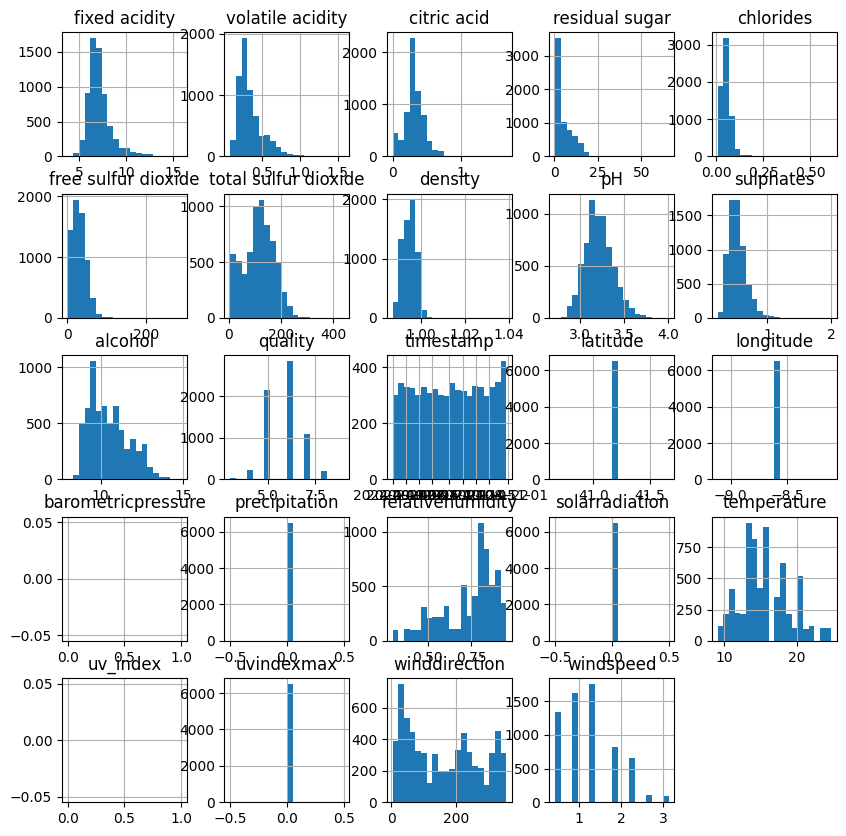

In [72]:
# Get the numerical variables from train_df
numerical_features = [feature for feature in df.columns if df[feature].dtype != object]
print(numerical_features)

df.hist(bins=20, figsize=(10, 10))
plt.show()

In [73]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


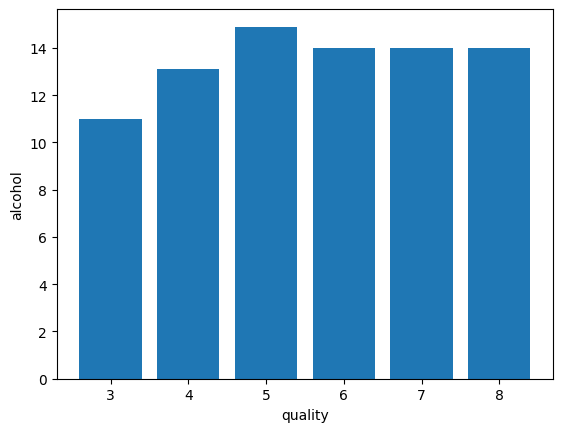

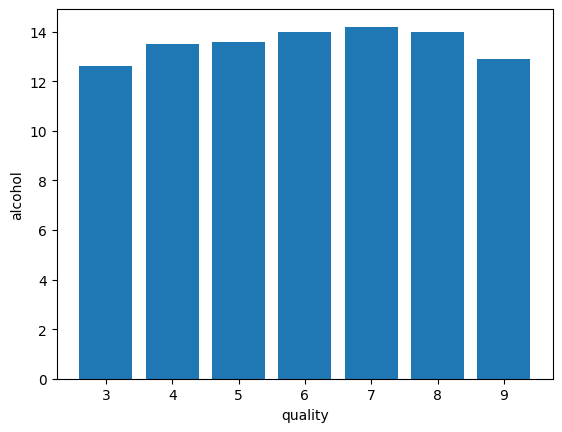

In [74]:
plt.bar(df1['quality'], df1['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

plt.bar(df2['quality'], df2['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()


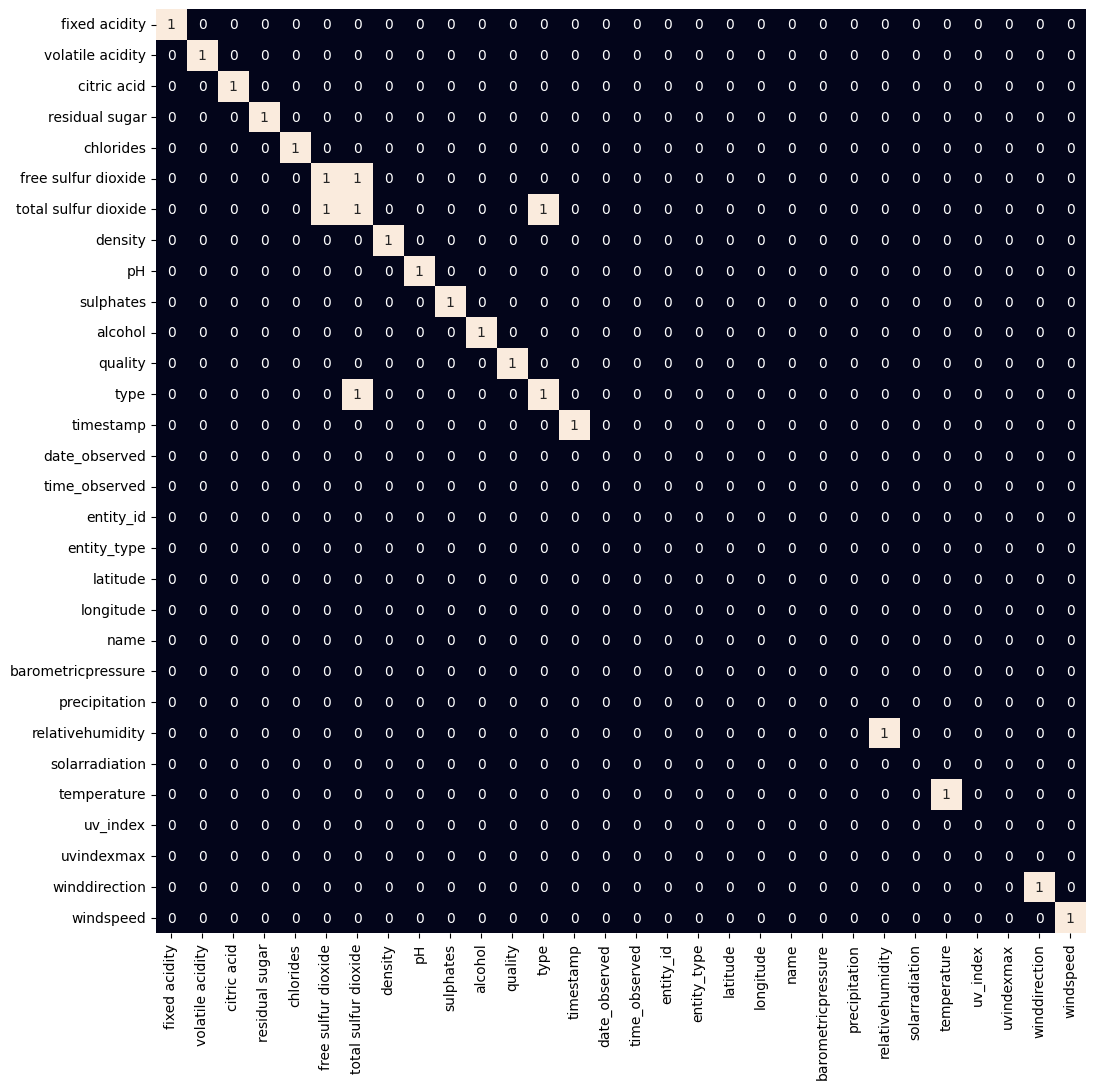

In [75]:
# Convert 'object' columns to numerical if they represent numbers
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
        except:
            pass  # Skip columns that cannot be converted

plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [76]:
# Drop unnecessary columns (adjust based on your analysis)
df.drop(columns=['entity_id', 'entity_type', 'name', 'latitude', 'longitude', 'date_observed', 'time_observed', 'barometricpressure', 'uv_index'], inplace=True)

# Extract year, month, and day (optional: use month to analyze growing season)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

df.drop(columns=['timestamp'], inplace=True)

In [77]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,type,precipitation,relativehumidity,solarradiation,temperature,uvindexmax,winddirection,windspeed,year,month
0,10.0,0.690,0.11,1.4,0.084,8.0,24.0,0.99578,2.88,0.47,...,0,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
1,6.3,0.150,0.30,1.4,0.022,38.0,100.0,0.99099,3.42,0.57,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
2,7.1,0.180,0.32,12.2,0.048,36.0,125.0,0.99670,2.92,0.54,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
3,8.2,0.400,0.48,13.7,0.042,59.0,169.0,0.99860,3.10,0.52,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
4,7.2,0.685,0.21,9.5,0.070,33.0,172.0,0.99710,3.00,0.55,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9


In [78]:
# # Train XGBoost to check feature importance
# xgb_model = xgb.XGBClassifier().fit(xtrain, ytrain)
# importances = pd.Series(xgb_model.feature_importances_, index=features.columns)

# # Plot feature importance
# importances.sort_values().plot(kind='barh', figsize=(10,6))
# plt.show()

In [79]:
df = df.drop('total sulfur dioxide', axis=1)
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]

In [80]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=40)

# Reset indices for alignment
xtest = pd.DataFrame(xtest, columns=features.columns).reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

# Impute missing values after splitting
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

LogisticRegression:
Training Accuracy: 0.7377333076775062
Validation Accuracy: 0.75
ROC AUC (Train): 0.7010225520627288
ROC AUC (Test): 0.7051742104314715
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.56      0.61       451
           1       0.78      0.85      0.82       849

    accuracy                           0.75      1300
   macro avg       0.73      0.71      0.71      1300
weighted avg       0.74      0.75      0.74      1300



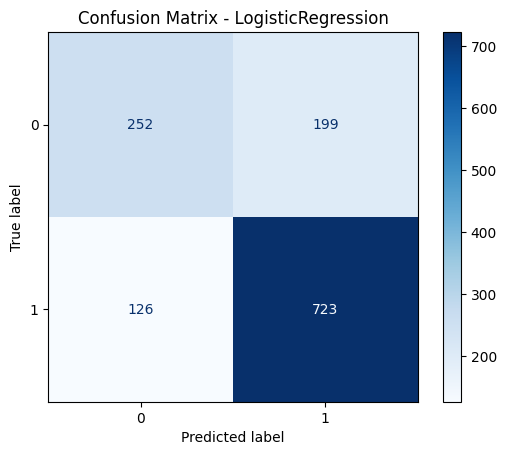

XGBClassifier:
Training Accuracy: 0.9878776217048297
Validation Accuracy: 0.8053846153846154
ROC AUC (Train): 0.986973936302405
ROC AUC (Test): 0.7803193531453464
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       451
           1       0.84      0.86      0.85       849

    accuracy                           0.81      1300
   macro avg       0.79      0.78      0.78      1300
weighted avg       0.80      0.81      0.80      1300



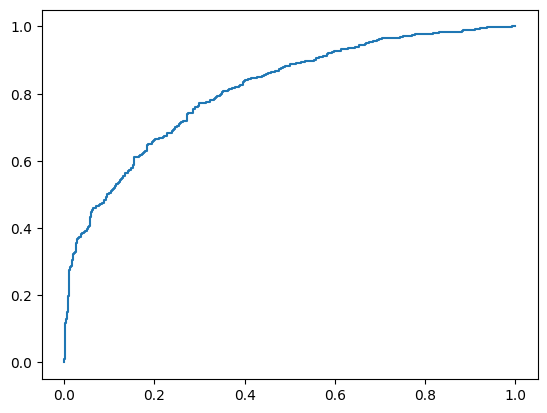

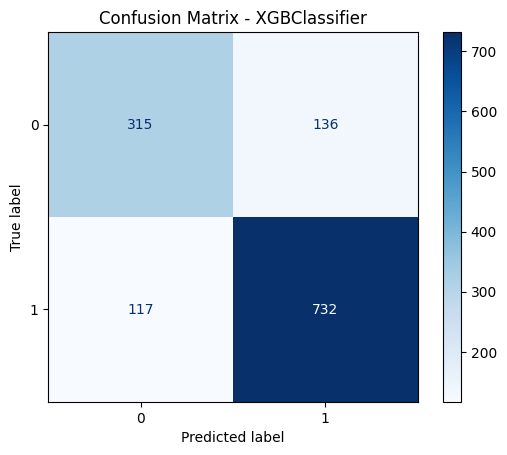

SVC:
Training Accuracy: 0.7496632672695785
Validation Accuracy: 0.7546153846153846
ROC AUC (Train): 0.7081995628049461
ROC AUC (Test): 0.704550024941303
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.54      0.60       451
           1       0.78      0.87      0.82       849

    accuracy                           0.75      1300
   macro avg       0.73      0.70      0.71      1300
weighted avg       0.75      0.75      0.75      1300



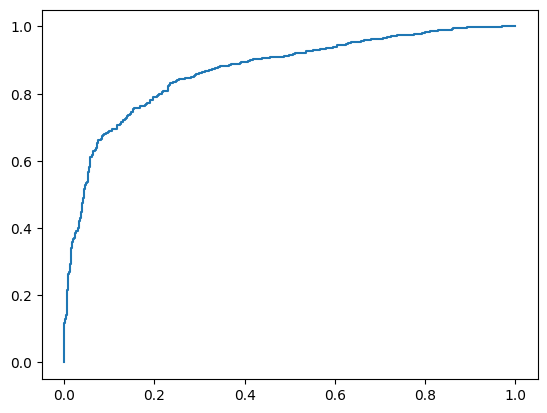

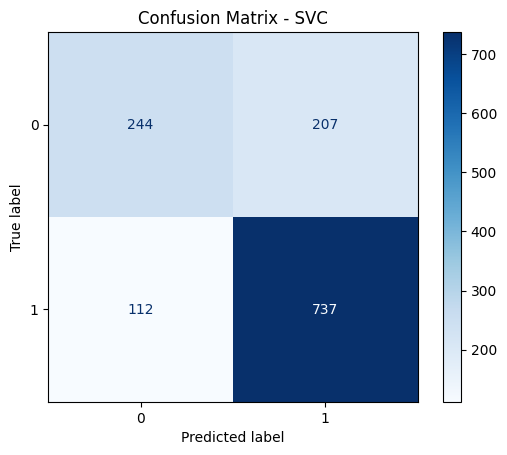

RandomForestClassifier:
Training Accuracy: 0.9998075812969021
Validation Accuracy: 0.823076923076923
ROC AUC (Train): 0.9997413347128815
ROC AUC (Test): 0.7923055427149196
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.69      0.73       451
           1       0.85      0.89      0.87       849

    accuracy                           0.82      1300
   macro avg       0.81      0.79      0.80      1300
weighted avg       0.82      0.82      0.82      1300



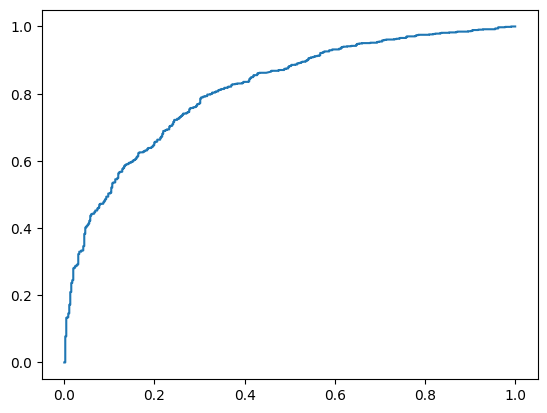

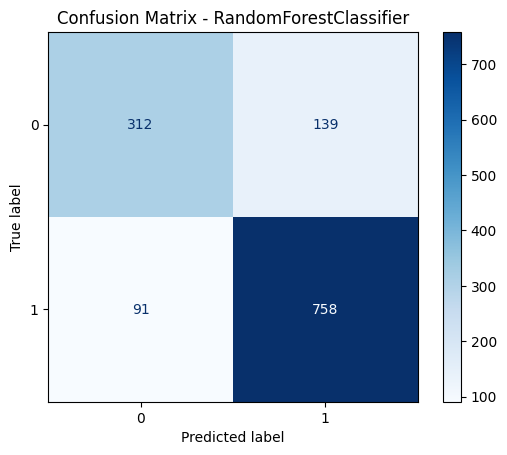

GradientBoostingClassifier:
Training Accuracy: 0.8012314796998268
Validation Accuracy: 0.7807692307692308
ROC AUC (Train): 0.7763615906140005
ROC AUC (Test): 0.7458820733404892
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       451
           1       0.81      0.86      0.84       849

    accuracy                           0.78      1300
   macro avg       0.76      0.75      0.75      1300
weighted avg       0.78      0.78      0.78      1300



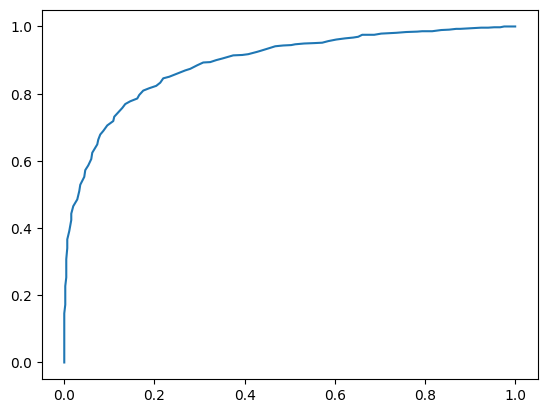

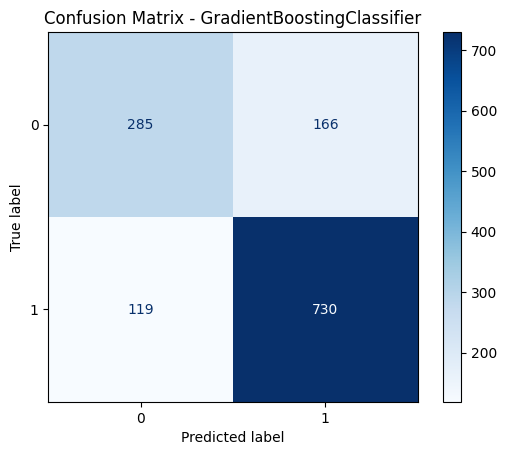

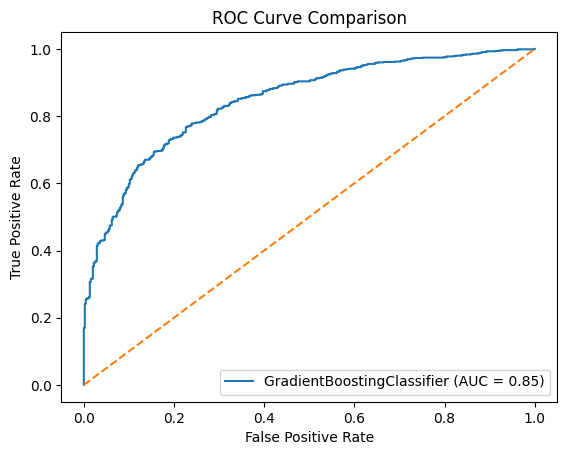

In [81]:
# Normalize
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

# Define models
models = [
    LogisticRegression(),
    XGBClassifier(),
    SVC(kernel='rbf', probability=True),  # Added probability=True for ROC curve
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42)
]

# Evaluate all models with additional error analysis
for model in models:
    print(f'{model.__class__.__name__}:')

    model.fit(xtrain, ytrain)
    # Predictions
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)
    ytest_proba = model.predict_proba(xtest)[:, 1] if hasattr(model, 'predict_proba') else None

    # Basic Evaluation
    print('Training Accuracy:', metrics.accuracy_score(ytrain, ytrain_pred))
    print('Validation Accuracy:', metrics.accuracy_score(ytest, ytest_pred))
    print('ROC AUC (Train):', roc_auc_score(ytrain, ytrain_pred))
    print('ROC AUC (Test):', roc_auc_score(ytest, ytest_pred))
    print('Classification Report:\n', classification_report(ytest, ytest_pred))

    # Confusion Matrix
    cm = confusion_matrix(ytest, ytest_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

    # ROC Curve
    if ytest_proba is not None:
        fpr, tpr, _ = roc_curve(ytest, ytest_proba)
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc_score(ytest, ytest_proba):.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [82]:
# Error Analysis for the best model (e.g., XGBClassifier)
best_model = models[1]  # Assuming XGBClassifier is best

# Identify false positives and false negatives
predictions = best_model.predict(xtest)
false_positives = (predictions == 1) & (ytest == 0)
false_negatives = (predictions == 0) & (ytest == 1)

print(f'False Positives: {np.sum(false_positives)}')
print(f'False Negatives: {np.sum(false_negatives)}')

False Positives: 136
False Negatives: 117


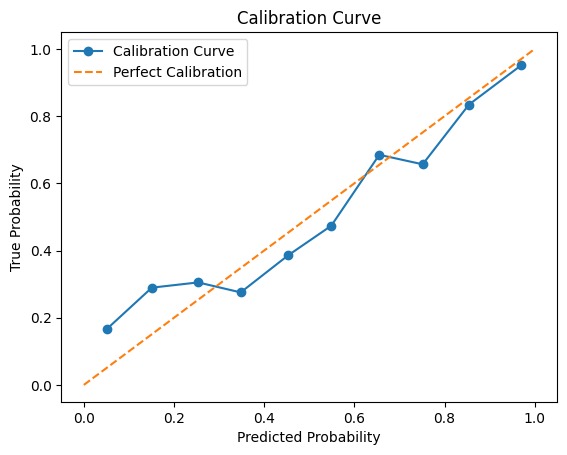

In [87]:
# Analyze feature distribution for errors
xtest_df = pd.DataFrame(xtest, columns=features.columns)

# # Plot distribution of key features for false positives vs true negatives
# for col in features.columns[:20]:  # Limiting to first 5 features for brevity
#     plt.figure(figsize=(8, 4))
#     sns.kdeplot(xtest_df.loc[false_positives, col], label='False Positives', color='red')
#     sns.kdeplot(xtest_df.loc[~false_positives, col], label='True Negatives', color='green')
#     plt.title(f'Distribution of {col} (False Positives vs True Negatives)')
#     plt.legend()
#     plt.show()

# Calibration Plot (Optional for probabilistic models)
if hasattr(best_model, 'predict_proba'):
    prob_true, prob_pred = calibration_curve(ytest, best_model.predict_proba(xtest)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

In [84]:
# To predict wine quality using weather conditions

# Predict Wine Quality for New Weather Conditions
# Create a new input DataFrame with the weather conditions (e.g., temperature, humidity, etc.).

# Preprocess the input data (imputation and scaling) using the same imputer and norm objects.

# Use the trained model to make predictions.

# Example:
# python
# Copy
# # New weather conditions (example)
# new_weather_data = {
#     'fixed acidity': [7.4],
#     'volatile acidity': [0.7],
#     'citric acid': [0.0],
#     'residual sugar': [1.9],
#     'chlorides': [0.076],
#     'free sulfur dioxide': [11.0],
#     'total sulfur dioxide': [34.0],
#     'density': [0.9978],
#     'pH': [3.51],
#     'sulphates': [0.56],
#     'alcohol': [9.4],
#     'temperature': [20.0],  # Example temperature
#     'relativehumidity': [70.0],  # Example humidity
#     'windspeed': [5.0]  # Example wind speed
# }

# # Convert to DataFrame
# new_data = pd.DataFrame(new_weather_data)

# # Preprocess the new data (imputation and scaling)
# new_data = imputer.transform(new_data)  # Use the same imputer
# new_data = norm.transform(new_data)  # Use the same scaler

# # Predict using the best model (e.g., RandomForestClassifier)
# best_model = RandomForestClassifier(n_estimators=100, random_state=42)
# best_model.fit(xtrain, ytrain)  # Ensure the model is trained
# predicted_quality = best_model.predict(new_data)

# print('Predicted Wine Quality:', predicted_quality)
# 5. Interpret Results
# The predicted_quality will be the output of your model (e.g., 0 or 1 for binary classification, or a numerical value for regression).

# You can also use predict_proba (for classification models) to get the probability of each class.

# 6. Key Considerations
# Feature Importance: Use techniques like SHAP or feature importance from the model to understand which weather variables (e.g., temperature) are most influential in predicting wine quality.

# Model Selection: Choose the best-performing model based on validation metrics (e.g., accuracy, ROC AUC).

# Data Quality: Ensure the new weather data is in the same format and scale as the training data.